# Image region of interest selection
This code helps you select multiple circular region of interests (ROIs) and then automatically saves them as .npy files in the same directory.

## Functions
1. Reads all the .npy files available in the directory in the numerical order of file name.
2. Opens .npy file in a loop and allows the user to select multiple ROIs.
3. Coordinates of each ROI is saved in a .txt file in the same directory.
4. Once ROIs are selected in all the images. .txt files are read by the code automatically.
5. Then ROIs are cropped and saved in the same directory.

## How to use
1. Make sure all the necessary python libraries are installed.
2. Copy the path to the image directory and past in directory_path.
3. Run the cell and a new dialog box should appear with the image.
4. Start selecting the ROIs in the images. You can select multiple ROIs by clicking and dragging the cursor. Take care not to randomly click on the image
otherwise point corrdinates are recorded and unnecessary files are created. To extract point spectra refer to point_roi.ipynb file in the dataset.
5. This code will run until all the images in the directory have been processed for ROI selection.
6. Once this script has finished. You should see .txt files in the directory and corresponding .npy ROIs files.

## Keyboard shortcuts
1. r: If you want to reset the selected pROIs in an image press 'r' in your keyboard. The previous ROIs are deleted and now you can select new ROIs.
2. c: Once you have marked all the ROIs in an image press 'c' to continue to the next image.
3. ESC: stops the processing in between. 

# Import necessary libraries

In [3]:
# importing the required libraries
import glob
import re
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

# Set the directory path here

In [4]:
# Specify the directory path to the image folder
directory_path = '/Users/billygrahamram/Downloads/kochia/'

# ROI selection, cropping and saving happens here

In [5]:
# Create a list of .npy files in the directory
npy_files = glob.glob(directory_path + '/*.npy')

# Function to extract numbers from the file name
def extract_number(f):
    s = re.findall("\d+",f)
    return (int(s[0]) if s else -1,f)

# Sort the list of .npy files in numerical order
npy_files = sorted(npy_files, key=extract_number)

# Print the sorted list of .npy files
print(npy_files)

def click_and_crop(event, x, y, flags, param):
    # grab references to the global variables
    global circles, current_circle, cropping, image

    # if the left mouse button was clicked, record the starting
    # (x, y) coordinates and indicate that cropping is being
    # performed
    if event == cv2.EVENT_LBUTTONDOWN:
        current_circle = [(x, y)]
        cropping = True

    # draw the circle while the mouse is moving and the left mouse button is down
    elif event == cv2.EVENT_MOUSEMOVE and cropping:
        image_temp = image.copy()
        radius = int(np.sqrt((x - current_circle[0][0])**2 + (y - current_circle[0][1])**2))
        cv2.circle(image_temp, current_circle[0], radius, (0, 255, 0), 2)
        cv2.imshow("image", image_temp)
        cv2.waitKey(1)  # Add a small delay to allow the window to refresh

    # check to see if the left mouse button was released
    elif event == cv2.EVENT_LBUTTONUP:
        # record the ending (x, y) coordinates
        current_circle.append((x, y))
        cropping = False # cropping is finished
        radius = int(np.sqrt((x - current_circle[0][0])**2 + (y - current_circle[0][1])**2))

        # draw a circle around the region of interest
        cv2.circle(image, current_circle[0], radius, (0, 255, 0), 2)
        cv2.imshow("image", image)
        # circles.append(tuple(current_circle))
        circles.append((current_circle[0], radius))

exit_loop = False

for file_path in npy_files:
    
    if exit_loop:
        break
    # load the image, clone it, and setup the mouse callback function
    circles = []
    current_circle = []
    cropping = False

    image = np.load(file_path)
    image = rgb2gray(image[:,:,[50,80,150]])
    image = ((image - image.min()) * (255 / (image.max() - image.min()))).astype(np.uint8)


    # Convert color from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    clone = image.copy()
    cv2.namedWindow("image")
    cv2.setMouseCallback("image", click_and_crop)

    # keep looping until the 'q' key is pressed
    while True:
        # display the image and wait for a keypress
        cv2.imshow("image", image)
        key = cv2.waitKey(1) & 0xFF

        # if the 'r' key is pressed, reset the cropping region
        if key == ord("r"):
            image = clone.copy()
            circles = []
            current_circle = []
            cropping = False

        # if the 'c' key is pressed, break from the loop
        elif key == ord("c"):
            break
        
                # press esc to stop the program
        elif key == 27:
            exit_loop = True
            break

    # close all open windows
    cv2.destroyAllWindows()


    # write circle to file
    # use os.path to get the base name of the file and replace the extension with .txt
    output_file_path = os.path.splitext(file_path)[0] + '.txt'
    with open(output_file_path, 'w') as f:
        for circle in circles:
            f.write(str(circle) + '\n')
            
            
            
# Create a list of .npy files in the directory
txt_files = glob.glob(directory_path + '/*.txt')

# Function to extract numbers from the file name
def extract_number(f):
    s = re.findall("\d+",f)
    return (int(s[0]) if s else -1,f)

# Sort the list of .npy files in numerical order
txt_files = sorted(txt_files, key=extract_number)

# Print the sorted list of .npy files
print(txt_files)



# For each .npy and .txt file pair
for npy_file_name, txt_file_name in zip(npy_files, txt_files):
    # Load the .npy file
    npy_file = np.load(npy_file_name)

    # Open the corresponding .txt file
    with open(txt_file_name, 'r') as f:
        lines = f.readlines()

    # For each line in the .txt file
    for i, line in enumerate(lines):
        # Parse the coordinates
        coords = eval(line.strip())
        center = coords[0]
        radius = coords[1]

        # Create a mask for the circular ROI
        mask = np.zeros(npy_file.shape[:2], dtype=np.uint8)
        cv2.circle(mask, center, radius, 255, -1)

        # # Apply the mask to the .npy file to get the circular ROI
        roi = npy_file * (mask[:, :, np.newaxis] // 255)
        # Crop the bounding box of the circular ROI
        x, y = center
        cropped_image = roi[y-radius:y+radius, x-radius:x+radius]

        # # Save the ROI as a separate .npy file
        base_name = os.path.splitext(npy_file_name)[0]
        np.save(f'{base_name}_cropped.npy', cropped_image)


['/Users/billygrahamram/Downloads/kochia/kochia_10.npy', '/Users/billygrahamram/Downloads/kochia/kochia_11.npy', '/Users/billygrahamram/Downloads/kochia/kochia_12.npy', '/Users/billygrahamram/Downloads/kochia/kochia_13.npy', '/Users/billygrahamram/Downloads/kochia/kochia_14.npy']


2024-10-11 14:34:44.936 Python[3425:196576] +[IMKClient subclass]: chose IMKClient_Legacy
2024-10-11 14:34:44.936 Python[3425:196576] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


['/Users/billygrahamram/Downloads/kochia/kochia_10.txt', '/Users/billygrahamram/Downloads/kochia/kochia_11.txt', '/Users/billygrahamram/Downloads/kochia/kochia_12.txt', '/Users/billygrahamram/Downloads/kochia/kochia_13.txt', '/Users/billygrahamram/Downloads/kochia/kochia_14.txt']


# ROI validation
Once the above script has completed you can check the individual ROI by running the following code. You will need to save replace the roi file path in the below code.

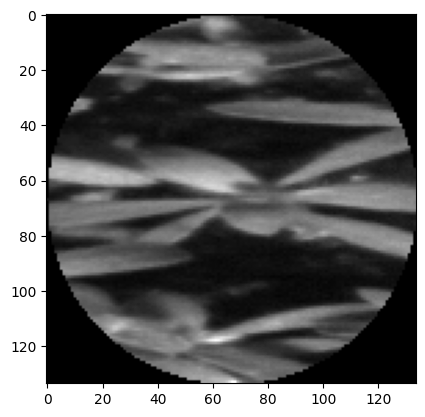

In [6]:
roi_directory = '/Users/billygrahamram/Downloads/kochia/kochia_10_cropped.npy'
file = np.load(roi_directory)
file = file[:,:,[80]]
plt.imshow(file, cmap='gray')
plt.show()